In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

trancuate_t = 96 # set this parameter to control at which time step you stop using the signal
# Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

Set Parameters

In [2]:
batch_size=128
num_convs = 10
grouped_time_steps = 1
r = 0


#### Model import correct model
from Naive_CNN_3D import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

AF = 5 #                # defined so far for noisy:3, 5, 10, 20, 40

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/Layer/model.pth"  # Replace with your file path
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_possoin_r0/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Alternating/5Layer/model.pth"
#saved_model_path = "../saved_models/Naive_CNN_3D_Non_Residual_AF_5_possoin_r0/5Layer/model.pth"
saved_model_path = f"../saved_models/Fitted_Naive_CNN_3D_AF_{AF}_possoin_r0_SingleCombination/{num_convs}Layer/model.pth"

#### Load data ####
Ground_Truth = np.load('../data/P04_And_P08_Spectral_Fit.npy')

Undersampled_Data = np.load(f'../data/Undersampled_Data/P04_P08_Fitted_undersampled_possoin_3D_fixed_r{r}_AF_{AF}_singleCombination.npy')

#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_possoin_3D_fixed_r0_AF_5.npy')
#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_Alternating_AF_3.npy')
#Undersampled_Data = np.load('../data/Undersampled_Data/combined_undersampled_possoin_3D_fixed_r0_AF_3.npy') ## Data set with accerleration factor 3

In [3]:
#### Train_Test_Split ####
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:,:,0], Ground_Truth[:,:,:,:,:,1]  # Method: Leave last MRSI measurement as test set

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:,:,0], Undersampled_Data[:,:,:,:,:,1]

#### Fourier transform ####
training_undersampled, test_undersampled = fourier_transform(NN_input_train), fourier_transform(NN_input_test)

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(22, 22, 21, -1), ground_truth_test.reshape(22, 22, 21, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(22, 22, 21, -1), NN_input_test.reshape(22, 22, 21, -1)
training_undersampled, test_undersampled = training_undersampled.reshape(22, 22, 21, -1), test_undersampled.reshape(22, 22, 21, -1)

#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)
_, normalized_train_FT, _ = normalize_data_per_image_new(NN_input_train, training_undersampled)
_, normalized_test_FT, _ = normalize_data_per_image_new(NN_input_test, test_undersampled)

#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps)

# Prepare k-space data (reshape undersampled k-space as well)
train_k_space = reshape_for_pytorch(normalized_train_FT, grouped_time_steps)
test_k_space = reshape_for_pytorch(normalized_test_FT, grouped_time_steps)

In [4]:
train_data.shape

(768, 2, 22, 22, 21)

In [5]:
#### Set parameters ####

# Create TensorDataset instances
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = Naive_CNN_3D(grouped_time_steps=grouped_time_steps, num_convs=num_convs, ).to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

Undersampling error / noise error: 119.08753


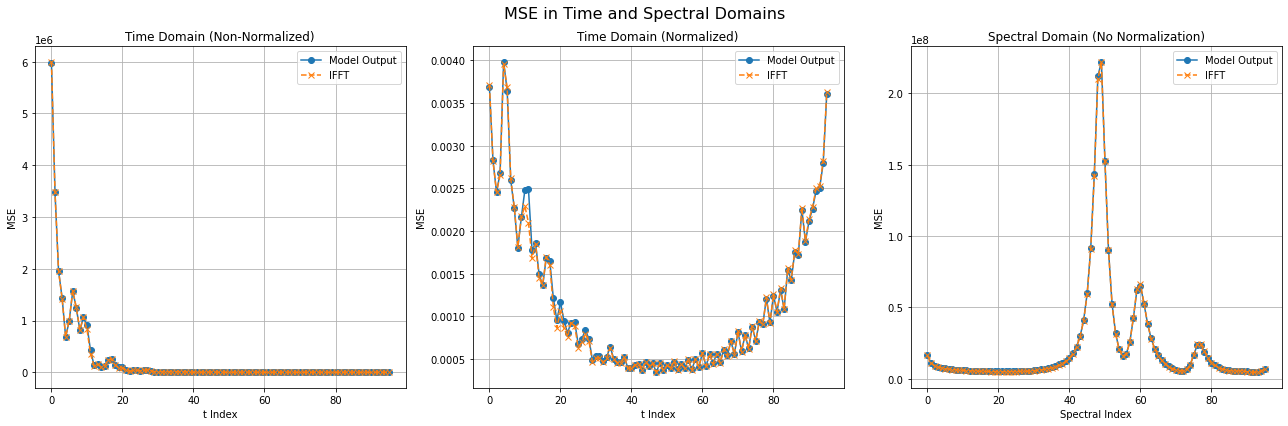

==== Model Output vs Ground Truth ====
Total MSE in image domain: 116431.125
Normalized Total MSE in image domain: 0.0005806927565468787
Total MSE in spectral domain: 11177387.00948629

==== Model Input vs Ground Truth ====
Total MSE in image domain: 115526.08333333333
Normalized Total MSE in image domain: 0.0005745747582051993
Total MSE in spectral domain: 11090506.01623589


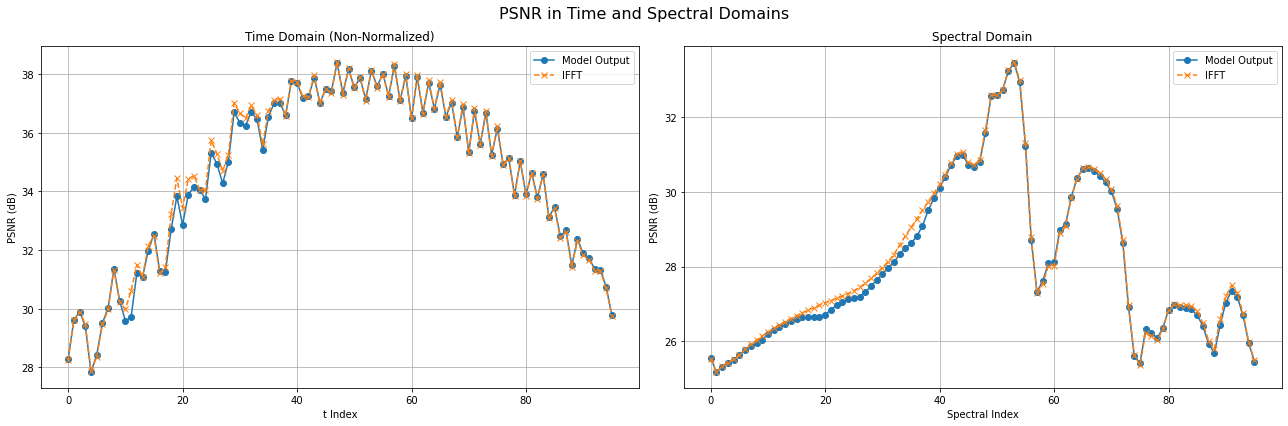

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    34.551727294921875
Average PSNR in frequency domain: 28.042101685802503

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    34.634239196777344
Average PSNR in frequency domain: 28.1307706381056


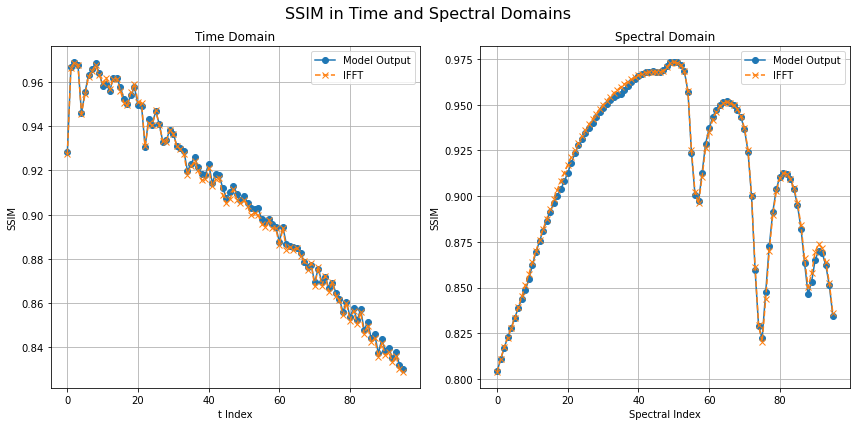

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.9058981877883182
Average SSIM in frequency domain: 0.9108460304529956

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.9048716778301357
Average SSIM in frequency domain: 0.9117042248359374


In [6]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

Noise = ground_truth[:, :, :, 95, :]   # e.g. shape: (X, Y, Z, coil_dim)

# Compute 2-norm per coil
two_norm_per_big_T = np.sqrt(np.sum(np.abs(Noise)**2, axis=(0, 1, 2)))
# shape of two_norm_per_coil is now (coil_dim,)

# Take the mean across coils
two_norm_noise_average = np.mean(two_norm_per_big_T)


model_input = Undersampled_Data[:,:,:,:,:,1]

Undersampling_Error = ground_truth[:, :, :, 0, :] - model_input[:, :, :, 0, :]  # e.g. shape: (X, Y, Z, coil_dim)

# Compute 2-norm per coil
two_norm_per_big_T = np.sqrt(np.sum(np.abs(Undersampling_Error)**2, axis=(0, 1, 2)))
# shape of two_norm_per_coil is now (coil_dim,)

# Take the mean across coils
two_norm_US_average = np.mean(two_norm_per_big_T)

Quotient = two_norm_US_average / two_norm_noise_average

print("Undersampling error / noise error:", Quotient)

norm_values_test = norm_values_test.reshape(96,8)




plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)

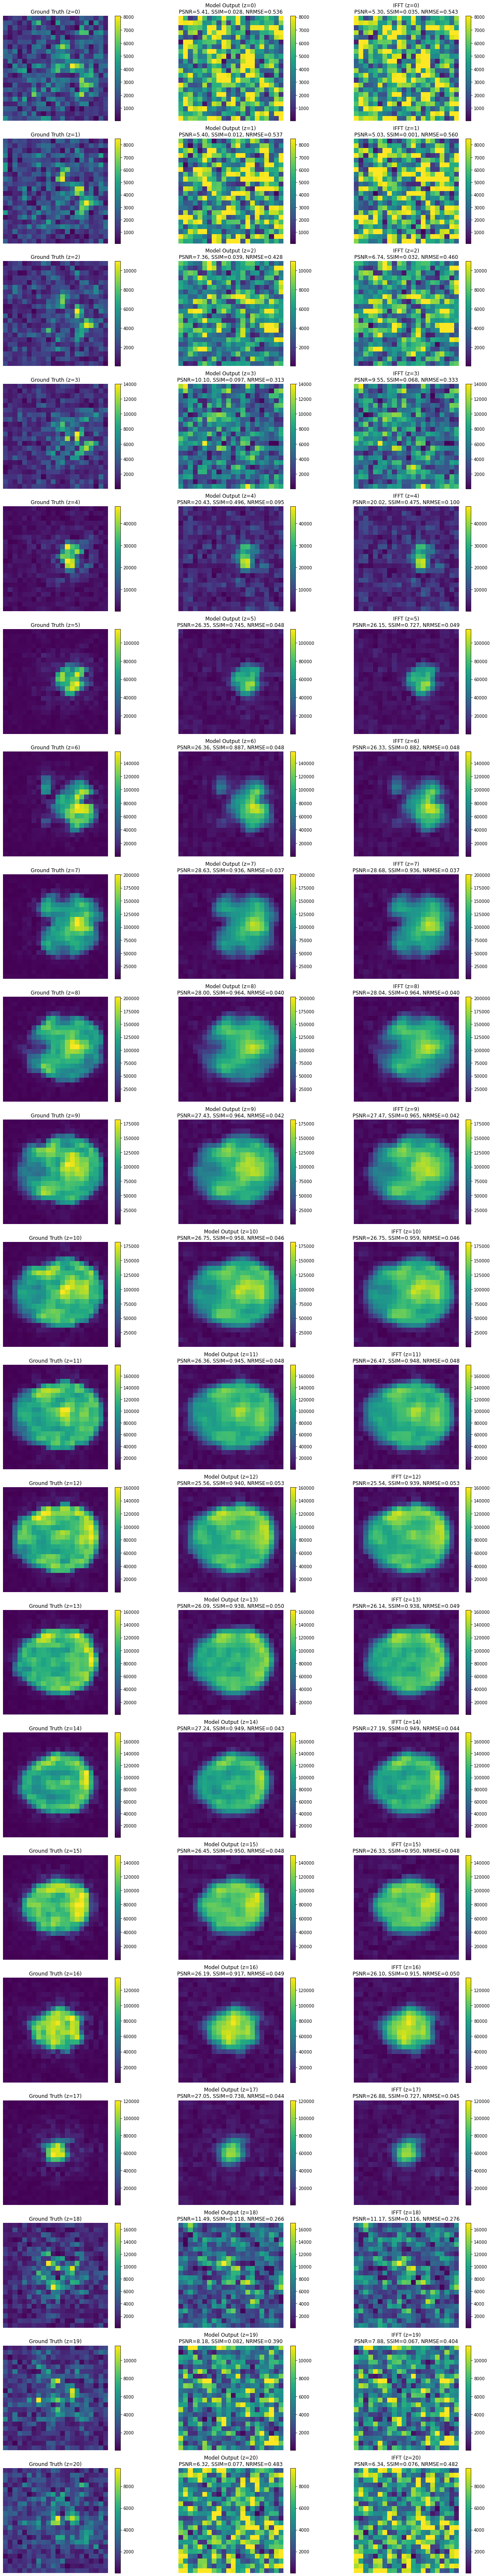

In [7]:
t = 60
T = 7
domain = "spectral"

model_input = Undersampled_Data[:,:,:,:,:,1]

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, t, T, domain=domain)

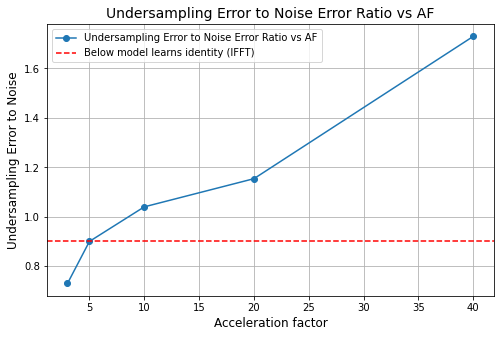

In [8]:
#### Note that the Ratio is computed in the statistics cell

AF = [3,5,10,20,40]
Ratio = [0.73, 0.9, 1.04, 1.154, 1.73]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(AF, Ratio, marker='o', linestyle='-', label='Undersampling Error to Noise Error Ratio vs AF')

plt.axhline(y=0.9, color='r', linestyle='--', label='Below model learns identity (IFFT)')

# Labels and title
plt.xlabel('Acceleration factor', fontsize=12)
plt.ylabel('Undersampling Error to Noise', fontsize=12)
plt.title('Undersampling Error to Noise Error Ratio vs AF', fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


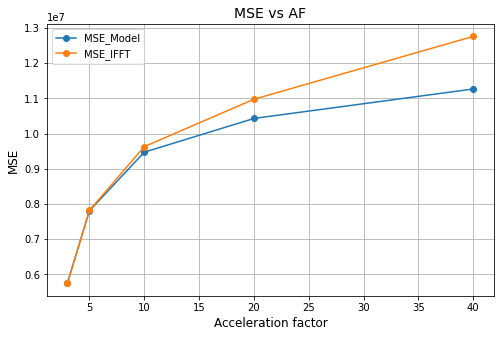

In [9]:
# Here I plot MSE in image domain vs AF

AF = [3,5,10,20,40]
MSE_Model = [5767337, 7808766, 9472584, 10431753, 11269272]
MSE_IFFT = [5742150, 7819783, 9631808, 10977836, 12765058]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(AF, MSE_Model, marker='o', linestyle='-', label='MSE_Model')

plt.plot(AF, MSE_IFFT, marker='o', linestyle='-', label='MSE_IFFT')

#plt.axvline(y=0.9, color='r', linestyle='--', label='Below model learns identity (IFFT)')

# Labels and title
plt.xlabel('Acceleration factor', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs AF', fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()